In [37]:
import typing
import lzma
import os
from pathlib import Path
from types import MappingProxyType, SimpleNamespace

import cbor2
import attrs
import tqdm.auto
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import jaxtyping as jt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arc25.symmetry import SymOp, transform_vector
from arc25 import serialisation
from arc25.dsl.types import Vector, Dir4
from arc25.vision.symrep import SymRep, SymDecomp, SymDecompDims, standard_rep
from arc25.vision.linear import SymmetricLinear
from arc25.vision.rope import QKV, attention_RoPE_with_global
from arc25.vision.fields import Field, FieldDims
from arc25.vision.attention import FieldAttention
from arc25.vision.classification import ARCClassifier


In [2]:

os.environ["XLA_FLAGS"]="--xla_force_host_platform_device_count=2"

In [3]:
proj_root = Path("..").resolve()
data_root = proj_root / "data"

In [4]:
with lzma.LZMAFile(data_root/"re-arc.cbor.xz","rb") as fh:
    src_data = serialisation.deserialise(cbor2.load(fh))

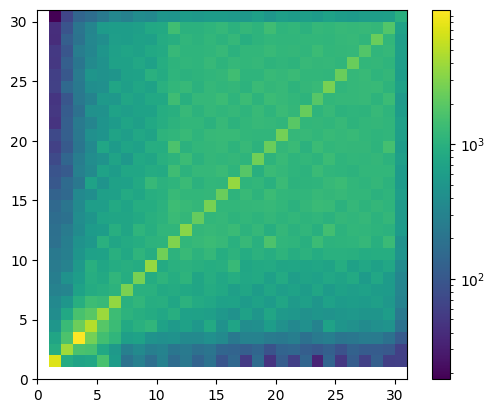

In [67]:

size_counts = np.zeros((31,31),int)
for k,v in src_data.items():
    for i,iop in enumerate(v):
        for kk in ["input","output"]:
            vv = getattr(iop,kk)
            if any(s>30 for s in vv.shape):
                continue 
            h,w = vv.shape
            size_counts[h,w] += 1

plt.pcolormesh(size_counts,norm="log")
plt.axis("square")
plt.colorbar()


In [93]:
import numba

def brute(size_counts,N=4):
    i = np.arange(0,31)
    ccounts = np.cumsum(np.cumsum(size_counts,axis=0),axis=1)
    ncells = i[:,None]*i
    total_cells = size_counts*ncells
    ccells = np.cumsum(np.cumsum(total_cells,axis=0),axis=1)
    mx = 30
    useful = ccells[mx,mx]
    best, bestb = brute_impl(ccounts,mx,N)
    return useful, best, bestb
    
@numba.njit
def brute_impl(ccounts,mx,N):
    best = 30**2*ccounts[-1,-1]
    bestb = np.zeros(N,dtype=np.int_)
    for b4 in range(4,mx):
        if N<=4:
            if b4>4:
                continue
            b4 = mx
        for b3 in range(3,mx):
            if N<=3:
                if b3>3:
                    continue
                b3 = mx
            for b2 in range(2,b3):
                if N<=2:
                    if b2>2:
                        continue
                    b2 = mx
                for b1 in range(1,b2):
                    j = np.array([0,b1,b2,b3,b4,mx])[:N+1]
                    j[-1] = mx
                    cc = ccounts[j,:][:,j]
                    bc = cc[1:]-cc[:-1]
                    bcnt = bc[:,1:]-bc[:,:-1]
                    bsz = j[1:,None]*j[1:]
                    spent = np.sum(bcnt*bsz)
                    if spent < best:
                        best = spent
                        bestb = j[1:]
    
    return best, bestb

for N in range(2,6):
    n_useful, n_spent, best = brute(size_counts, N=N)
    print(f"With {N=}, waste {(n_spent-n_useful)/1e6:.1f}/{n_spent/1e6:.1f} M (efficiency {100*n_useful/n_spent:.1f} %) with {best}")
            

With N=2, waste 199.2/422.9 M (efficiency 52.9 %) with [16 30]
With N=3, waste 121.2/344.9 M (efficiency 64.9 %) with [12 21 30]
With N=4, waste 86.3/310.0 M (efficiency 72.2 %) with [11 17 24 30]
With N=5, waste 64.7/288.4 M (efficiency 77.6 %) with [ 8 14 20 25 30]


In [94]:
dataset = []
size_cuts = np.r_[11,17,24,30]
#size_cuts = np.r_[20,30]
skipped = []
for k,v in tqdm.auto.tqdm(src_data.items()):
    for i,iop in enumerate(v):
        for kk in ["input","output"]:
            vv = getattr(iop,kk)
            if any(s>30 for s in vv.shape):
                skipped.append(vv)
                continue
            gs = tuple(int(size_cuts[np.searchsorted(size_cuts,s)]) for s in vv.shape)
            dataset.append(dict(
                image = vv._data,
                shape = vv.shape,
                size = int(np.prod(vv.shape)),
                grouping_shape = gs,
                challenge = k,
                type = kk,
            ))
print(f"Skipped {len(skipped)} out of {len(skipped)+len(dataset)} due to out-of-range shape")
datasrc = pd.DataFrame(dataset)
datasrc.head()

  0%|          | 0/400 [00:00<?, ?it/s]

Skipped 258 out of 800000 due to out-of-range shape


,image,shape,size,grouping_shape,challenge,type
0,"[[7, 7, 7, 7, 6, 7, 7, 7, 7], [7, 7, 7, 7, 7, ...","(6, 9)",54,"(11, 11)",a85d4709,input
1,"[[4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 3, 3, 3, 3, ...","(6, 9)",54,"(11, 11)",a85d4709,output
2,"[[6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6], [6, 6, ...","(15, 12)",180,"(17, 17)",a85d4709,input
3,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 3, ...","(15, 12)",180,"(17, 17)",a85d4709,output
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...","(2, 24)",48,"(11, 24)",a85d4709,input


In [95]:
total_waste = 0
total_cells = 0
min_grp = 1000000
for gs,grp in datasrc.groupby("grouping_shape"):
    s = gs[0]*gs[1]*grp.shape[0]
    n = grp["size"].sum()
    util = n/s
    waste = s-n
    total_waste += waste
    total_cells += n
    min_grp = min(min_grp, grp.shape[0])
    print(f"Group {str(gs):8s} has {grp.shape[0]:6} with an average utilisation of {util*100:.0f} %, wasting {waste*1e-3:.1f}k cells")
print(f"Total waste: {total_waste*1e-6:.1f}M cells vs {total_cells*1e-6:.1f}M useful cells")
print(f"Maximum batch size / minimum group size: {min_grp}")

Group (11, 11) has 139109 with an average utilisation of 30 %, wasting 11831.6k cells
Group (11, 17) has  44672 with an average utilisation of 58 %, wasting 3509.8k cells
Group (11, 24) has  44197 with an average utilisation of 61 %, wasting 4508.7k cells
Group (11, 30) has  33102 with an average utilisation of 64 %, wasting 3923.8k cells
Group (17, 11) has  43996 with an average utilisation of 59 %, wasting 3409.3k cells
Group (17, 17) has  51061 with an average utilisation of 73 %, wasting 4047.3k cells
Group (17, 24) has  47995 with an average utilisation of 75 %, wasting 4932.7k cells
Group (17, 30) has  37059 with an average utilisation of 78 %, wasting 4243.0k cells
Group (24, 11) has  43185 with an average utilisation of 62 %, wasting 4304.0k cells
Group (24, 17) has  48750 with an average utilisation of 75 %, wasting 5037.0k cells
Group (24, 24) has  65856 with an average utilisation of 77 %, wasting 8872.9k cells
Group (24, 30) has  45089 with an average utilisation of 80 %, w

In [96]:
import xarray as xa

challenge_index = pd.CategoricalIndex(sorted(datasrc.challenge.unique()))
itype_index = pd.CategoricalIndex(sorted(datasrc.type.unique()))
challenge_index, itype_index

(CategoricalIndex(['007bbfb7', '00d62c1b', '017c7c7b', '025d127b', '045e512c',
                   '0520fde7', '05269061', '05f2a901', '06df4c85', '08ed6ac7',
                   ...
                   'f8b3ba0a', 'f8c80d96', 'f8ff0b80', 'f9012d9b', 'fafffa47',
                   'fcb5c309', 'fcc82909', 'feca6190', 'ff28f65a', 'ff805c23'],
                  categories=['007bbfb7', '00d62c1b', '017c7c7b', '025d127b', ..., 'fcc82909', 'feca6190', 'ff28f65a', 'ff805c23'], ordered=False, dtype='category', length=400),
 CategoricalIndex(['input', 'output'], categories=['input', 'output'], ordered=False, dtype='category'))

In [97]:
padded_data = {}
for gs,grp in datasrc.groupby("grouping_shape"):
    n = grp.shape[0]
    images = np.zeros((n,)+gs,"i1")
    sizes = np.zeros((n,2),int)
    challenges = np.zeros((n,),int)
    itype = np.zeros((n,),int)
    for i,(_,row) in enumerate(grp.iterrows()):
        h,w = row["shape"]
        images[i,:h,:w] = row.image
        sizes[i,:] = h,w
        challenges[i] = challenge_index.get_loc(row.challenge)
        itype[i] = itype_index.get_loc(row.type)
    data = xa.Dataset(
        dict(
            images = (("idx","row","col"), images),
            sizes = (("idx","dim"), sizes),
            challenges = (("idx",),challenges),
            itype = (("idx",),itype),
        ),
        coords = dict(
            dim = pd.Index(["row","col"]),
        ),
    )
    padded_data[gs] = data
data

<xarray.Dataset> Size: 39MB
Dimensions:     (idx: 41313, row: 30, col: 30, dim: 2)
Coordinates:
  * dim         (dim) object 16B 'row' 'col'
Dimensions without coordinates: idx, row, col
Data variables:
    images      (idx, row, col) int8 37MB 6 6 6 6 6 6 6 6 6 ... 0 0 0 0 0 0 0 0
    sizes       (idx, dim) int64 661kB 29 30 29 30 28 27 ... 29 26 25 28 25 28
    challenges  (idx) int64 331kB 261 261 261 261 261 ... 233 233 233 233 233
    itype       (idx) int64 331kB 0 1 0 1 0 1 0 1 0 1 0 ... 0 1 0 1 0 1 0 1 0 1

In [98]:
def make_dataset(batch_size: int, rngs:nnx.Rngs):
    weights = {}
    for gs,data in padded_data.items():
        weights[gs] = data.idx.size
    logits = np.log(np.array(list(weights.values())))
    keys = tuple(weights.keys())
    rng = rngs
    warmup = 0
    while True:
        if warmup is None or warmup>=len(keys):
            warmup = None
            gs = keys[rng.categorical(logits)]
        else:
            gs = keys[warmup]
            warmup += 1
        data = padded_data[gs]
        assert data.idx.size >= batch_size
        i = set()
        while len(i) < batch_size:
            j = rng.randint((batch_size-len(i),),0,data.idx.size)
            i.update(int(v) for v in j)
        i = np.array(sorted(i))
        images = data.images.to_numpy()[i]
        sizes = data["sizes"].to_numpy()[i]
        labels = data.challenges.to_numpy()[i]
        yield dict(
            inputs = dict(image=images, size=sizes),
            label = labels,
        ), warmup is not None

In [99]:
import dataclasses
from dataclasses import dataclass

In [100]:
@dataclass(frozen=True)
class ModelConfig:
    num_classes: int = 1000
    embed_dim: int = 256

@dataclass(frozen=True)
class TrainConfig:
    """Configuration for the training script."""
    seed: int = 42
    global_batch_size: int = 128  # across all devices
    ref_batch: int = 1024 # all learning rates refer to this batch size
    ref_epoch: int = 800000 # number of images that we call one epoch in reporting
    # Optimiser
    learning_rate: float = 3e-4
    betas: tuple[float, float] = (0.9, 0.999)
    eps: float = 1e-8
    weight_decay: float = 0.05
    grad_clip_norm: float = 1.0
    # Schedule    
    # in units of ref_batch images!
    num_train_steps: int = 1000
    warmup_steps: float = 10
    log_every_steps: int = 50

    # TODO: EMA


In [101]:

class TrainState(nnx.Module):
    """A frozen dataclass to hold the training state."""
    config: TrainConfig = dataclasses.field(metadata=dict(static=True))
    model: nnx.Module
    optimizer: nnx.Optimizer
    # ema_params: nnx.Params

    @classmethod
    def make(
        cls,
        model: nnx.Module,
        config: TrainConfig,
        *,
        rngs: nnx.Rngs,
    ) -> typing.Self:
        """Initializes the model, optimizer, and the combined training state."""

        step_scale = config.ref_batch / config.global_batch_size
        epoch_scale = config.ref_epoch / config.global_batch_size
        # Create the learning rate schedule (warmup + cosine decay is standard for ViTs)
        # with Linear LR scaling
        lr = config.learning_rate / step_scale
        zero_lr = lr * 0.001
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=zero_lr,
            peak_value=config.learning_rate,
            warmup_steps=int(round(config.warmup_steps*step_scale)),
            decay_steps=int(round((config.num_train_steps - config.warmup_steps)*step_scale)),
            end_value=zero_lr,
        )
    
        # Create the AdamW optimizer with gradient clipping
        tx = optax.chain(
            optax.clip_by_global_norm(config.grad_clip_norm),
            optax.adamw(
                learning_rate=lr_schedule,
                weight_decay=config.weight_decay,
                b1=config.betas[0],
                b2=config.betas[1], 
                eps=config.eps,
            ),
        )

        self = cls()
        self.config = config
        self.model = model
        self.optimizer = nnx.Optimizer(model, tx, wrt=nnx.Param)
        self.stats = {k:nnx.Variable(0) for k in ["steps","examples"]}

        return self

    def model_stats(self):
        stats = {}
        for k in ["model","optimizer"]:
            _, v = nnx.split(getattr(self, k))
            leaves = jax.tree_util.tree_leaves(v)
            total_params = sum((leaf.size for leaf in leaves), start=0)
            total_bytes = sum((leaf.nbytes for leaf in leaves), start=0)
            stats[k] = SimpleNamespace(params=total_params,bytes=total_bytes)
        
        return SimpleNamespace(**stats)

    @classmethod
    def loss_fn(cls, model, batch):
        inputs = batch["inputs"]
        logits = model(inputs["image"], inputs["size"])
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch["label"],
            #label_smoothing=cfg.label_smoothing,
        ).mean()
        accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == batch["label"])
        return loss, dict(loss=loss, accuracy=accuracy)

    def batch_stats(self, batch_size:int|None=None,shape:tuple[int,int] = (30,30)):
        graph, state = nnx.split(self)
        def inference(state, batch):
            state = nnx.merge(graph, state)
            model = state.model
            model.eval()
            inputs = batch["inputs"]
            return model(inputs["image"], inputs["size"])
        def train(state, batch):
            state = nnx.merge(graph, state)
            model = state.model
            model.train()
            def loss_fn(model):
                return self.loss_fn(model, batch)
            grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
            (_, stats), grads = grad_fn(model)

            # Update optimizer state and compute new parameters
            state.optimizer.update(state.model, grads)
            _, state = nnx.split(state)
            return state, stats
            
        if batch_size is None:
            batch_size = self.config.global_batch_size
        batch = dict(
            inputs = dict(
                image = np.zeros((batch_size,)+shape,"i1"),
                size = np.tile(shape,(batch_size,1)),
            ),
            # TODO: num classes!
            label = np.arange(batch_size,dtype=int)%400,
        )
        stats = {}
        for k,fun in dict(
            inference=inference,
            train=train,
        ).items():
            # Analyze the forward pass function
            jfun = jax.jit(fun)
            tfun = jfun.trace(state, batch)
            cfun = tfun.lower()#.compile()
            cost = cfun.cost_analysis()
            stats[k] = SimpleNamespace(
                flops = cost.get("flops"),
                bytes_accessed = cost.get("bytes accessed"),
                bytes_out = cost.get("bytes accessedout"),
            )
            
        return SimpleNamespace(**stats)

    def train_step(self, batch, num_devices):
        @nnx.split_rngs(splits=num_devices)
        def wrapper(state, batch):
            return state._parallel_train_step(batch)

        batch = jax.tree.map(lambda x:x.reshape(num_devices,-1,*x.shape[1:]), batch)
        stats = wrapper(self, batch)

        # TODO: this one probably defeats latency hiding
        stats = jax.device_get(jax.tree.map(lambda x: x[0], stats))
        self.stats["steps"] += 1
        self.stats["examples"] += batch["label"].shape[0]
        stats.update({k:v.value for k,v in self.stats.items()})
        return stats

        
    @nnx.pmap(axis_name="data",in_axes=(nnx.StateAxes({('data',nnx.RngKey,nnx.RngCount): 0, ...: None}),0))
    def _parallel_train_step(self, batch):
        def loss_fn(model):
            return self.loss_fn(model, batch)

        grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
        (_, stats), grads = grad_fn(self.model)

        grads = jax.lax.pmean(grads, axis_name='data')
        stats = jax.lax.pmean(stats, axis_name='data')
        
        self.optimizer.update(self.model, grads)
        return stats        


In [102]:
import time 

def main(model, config: TrainConfig):
    """The main entry point for the training script."""
    # Detect available devices (GPUs/TPUs)
    num_devices = jax.local_device_count()
    is_multi_device = num_devices > 1

    per_device_batch_size = config.global_batch_size // num_devices
    config = dataclasses.replace(config, global_batch_size=per_device_batch_size*num_devices)

    step_scale = config.ref_batch / config.global_batch_size
    epoch_scale = config.ref_epoch / config.global_batch_size
    
    print(f"--- ARC ViT Pre-training ---")
    print(f"Detected {num_devices} devices: {jax.devices()}")
    print(f"Mode: {'Single-device' if not is_multi_device else 'Multi-device (DDP)'}")
    print(f"Per-device batch size: {per_device_batch_size}")
    print(f"Global batch size: {config.global_batch_size}")
    print("----------------------------\n")

    # Setup PRNG key
    rngs = nnx.Rngs(config.seed)

    # 1. Setup Data Pipeline
    # ...

    # 2. Initialize Training State
    state = TrainState.make(
        model,
        config,
        rngs=rngs,
    )
    
    # 4. Start the training loop
    print("Starting training...")
    start_time = time.monotonic()
    start_imgs = 0
    
    # Get an iterator for the dataset
    ds_iter = iter(make_dataset(config.global_batch_size, rngs=rngs))

    try:
        was_warmup = True
        stats = {}
        for step in (pbar := tqdm.auto.trange(int(round(config.num_train_steps*step_scale)))):
            # Fetch the next batch of data
            batch,is_warmup = next(ds_iter)
            if was_warmup and not is_warmup:
                print(f"Warmup/JIT complete!")
                was_warmup = False
                start_time = time.monotonic()
                start_imgs = step*config.global_batch_size  
            
            # Execute one parallel training step
            s = state.train_step(batch, num_devices)
    
            elapsed_time = time.monotonic() - start_time
            images = (step+1)*config.global_batch_size
            images_per_sec = images / elapsed_time
            info = dict(
                #step=step,
                refstep = images/config.ref_batch,
                epoch= images/config.ref_epoch,
                images = images,
                images_per_sec=images_per_sec,
                seconds_per_epoch=config.ref_epoch/images_per_sec,
                **s
            )
            for k,v in info.items():
                stats.setdefault(k,[]).append(v)
            pbar.set_postfix(**{
                dict(images_per_sec="ips").get(k,k):f"{info[k]:.{v}f}"
                for k,v in dict(
                    loss=2,
                    accuracy=3,
                    images_per_sec=2,
                    epoch=2,
                    refstep=2,
                ).items()
            })
    except KeyboardInterrupt:
        pass

    print("\n--- Training Finished ---")
    stats = {k:np.array(v) for k,v in stats.items()}
    stats = pd.DataFrame(stats)
    return stats

In [103]:
dims = FieldDims.make(
    inv_fac = 2,
    context = 32,
    hdrs = 16,
    cells = 16,
)
arc_cls = ARCClassifier(
    hidden_size = dims,
    mha_features = 96,
    mlp_width_factor = 2,
    num_heads = 3,
    num_classes = 400,
    num_layers = 8,
    rngs = nnx.Rngs(0),
)

In [108]:
config = TrainConfig(
    global_batch_size = 8,
    num_train_steps = 100,
    warmup_steps = 0.25,
    learning_rate = 3e-4,
    weight_decay = 0.05,
)

In [109]:
import humanize

def print_stats(stats,path=()):
    for k,v in vars(stats).items():
        p = path+(k,)
        if isinstance(v, SimpleNamespace):
            print_stats(v, p)
            continue
        if v is None:
            continue
        if "bytes" in k:
            n = humanize.naturalsize(v,binary=True)
        else:
            n = humanize.naturalsize(v,gnu=True,format="%.1f ")
            if n.endswith("B"):
                n = n[:-1]+" "
        if "flops" in k:
            n += "FLOPs"
        print(f"{'.'.join(p):32s}: {n}")


ts = TrainState.make(model=arc_cls, config=config, rngs=nnx.Rngs(0))
stats = SimpleNamespace(model=ts.model_stats(),batch=ts.batch_stats())
leaves = [
    a for p in dims.make_empty(
        batch=(config.global_batch_size,),
        shape=(30,30),
        flavours=11,
    ).projections.values() for a in p.representations.values()
]
stats.fields = SimpleNamespace(params=sum(a.size for a in leaves),bytes=sum(a.nbytes for a in leaves))
print_stats(stats)

model.model.params              : 2.6 M
model.model.bytes               : 10.3 MiB
model.optimizer.params          : 5.1 M
model.optimizer.bytes           : 20.5 MiB
batch.inference.flops           : 647.4 GFLOPs
batch.inference.bytes_accessed  : 274.0 GiB
batch.train.flops               : 1.8 TFLOPs
batch.train.bytes_accessed      : 902.0 GiB
fields.params                   : 12.6 M
fields.bytes                    : 100.8 MiB


In [ ]:
stats = main(arc_cls, config)

--- ARC ViT Pre-training ---
Detected 2 devices: [CpuDevice(id=0), CpuDevice(id=1)]
Mode: Multi-device (DDP)
Per-device batch size: 4
Global batch size: 8
----------------------------

Starting training...


  0%|          | 0/12800 [00:00<?, ?it/s]

Warmup/JIT complete!


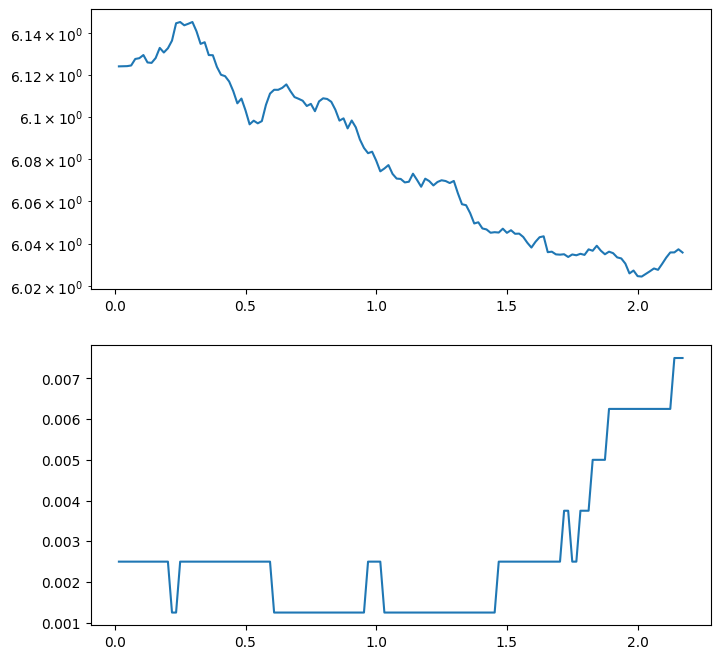

In [107]:
import matplotlib.pyplot as plt
from scipy import ndimage

filter_width = 50

fig,axes = plt.subplots(2,1,figsize=(8,8))
ax = axes[0]
ax.semilogy(stats.refstep, ndimage.uniform_filter1d(stats.loss,filter_width))
ax = axes[1]
ax.plot(stats.refstep, ndimage.uniform_filter1d(stats.accuracy,filter_width))

In [19]:
state = TrainState.make(
    arc_cls,
    TrainConfig(),
    rngs=nnx.Rngs(0),
)
state.tx.

SyntaxError: invalid syntax (1220329170.py, line 6)

In [ ]:
class Count(nnx.Variable): pass


class Weights(nnx.Module):
    def __init__(self, kernel, bias, count, seed):
        self.kernel, self.bias = nnx.Param(kernel), nnx.Param(bias)
        self.count = Count(count)
        self.rngs = nnx.Rngs(noise=seed)

    def __call__(self, x):
        y = x @ self.kernel + self.bias
        y = y + jax.random.normal(self.rngs.noise(), y.shape)
        return y
  

In [ ]:
import contextlib

class TrainState(nnx.Module):
    model: Weights
    optimizer: optax.GradientTransformation
    stats: dict[str,nnx.Variable]

    @classmethod
    def make_fresh(cls, model):
        tx = optax.adam(1e-2)
        self = cls()
        self.model = model
        self.optimizer = nnx.Optimizer(model, tx, wrt=nnx.Param)
        self.stats = {k:nnx.Variable(0) for k in ["steps","examples"]}
        return self

    @contextlib.contextmanager
    def parallel_training(self, num_devices:int):
        state_axes = nnx.StateAxes({('data',nnx.RngKey,nnx.RngCount): 0, ...: None})
        
        @nnx.split_rngs(splits=num_devices)
        @nnx.pmap(axis_name="data",in_axes=(state_axes,0))#, out_axes=0)
        def train_step(state: typing.Self, batch):
            def loss_fn(model):
                preds = model(batch["x"])
                loss = jnp.mean((preds - batch["y"]) ** 2)
                mae = jnp.mean(jnp.abs(preds - batch["y"]))
                return loss, dict(loss=loss,mae=mae)

            grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
            (_, stats), grads = grad_fn(state.model)
            #stats = dict(loss=loss, mae=mae)
        
            # Average gradients and metrics across all devices.
            # This is the core of data-parallel training.
            grads = jax.lax.pmean(grads, axis_name='data')
            stats = jax.lax.pmean(stats, axis_name='data')
            #stats = {k:jax.lax.pmean(v, axis_name='data') for k,v in stats.items()}
            
            # apply update (updates model params in-place, updates optimizer.opt_state)
            state.optimizer.update(state.model, grads)
            print("step")
#            return
            return stats
        

        def step_fun(batch):
            nonlocal self
            batch = jax.tree.map(lambda x:x.reshape(num_devices,-1,*x.shape[1:]), batch)
            stats = train_step(self, batch)
            stats = jax.device_get(jax.tree.map(lambda x: x[0], stats))
            self.stats["steps"] += 1
            self.stats["examples"] += batch["x"].shape[0]
            stats.update({k:v.value for k,v in self.stats.items()})
            return stats
        try:
            yield step_fun
        finally:
            nnx.update(self, state)

In [ ]:
weights = Weights(
  kernel=jax.random.uniform(jax.random.key(0), (2, 3)),
  bias=jnp.zeros((3,)),
  count=jnp.array(0),
  seed=0,
)
state = TrainState.make_fresh(weights)

x = jax.random.normal(jax.random.key(1), (128, 2))
y = jax.random.normal(jax.random.key(1), (128, 3))

with state.parallel_training(8) as step_fun:
    stats = step_fun(dict(x=x,y=y))
print(stats)

In [ ]:
n_dev = 8


x = jax.random.normal(jax.random.key(1), (n_dev, 2))

state_axes = nnx.StateAxes({nnx.RngState: 0, (nnx.Param, Count): None})

w = Split(*nnx.split(weights, nnx.Param, ...))

def base(w: Split, x: jax.Array):
  weights = nnx.merge(w.gd, w.s, w.os)
  assert weights.kernel.ndim == 2, 'Batch dimensions not allowed'
  assert x.ndim == 1, 'Batch dimensions not allowed'
  weights.count += 1
  y = x @ weights.kernel + weights.bias
  res = y + jax.random.normal(weights.rngs.noise(), y.shape)
  nw = Split(*nnx.split(weights, nnx.Param, ...))
  return res, nw

tfo = nnx.pmap(
    base,
#    in_axes=(state_axes, 0),
    axis_name='data',
)
tfo = nnx.split_rngs(splits=n_dev)(tfo)

ws = dataclasses.replace(
    w,
    s=jax.device_put_replicated(w, jax.local_devices())

y1,ws1 = tfo(ws, x)
y2,ws2 = tfo(ws1, x)

print(jnp.allclose(y1, y2))
nnx.display(weights)

In [ ]:
ws.gd

In [ ]:
ws.os